In [1]:
## import json
import rasterio
import rasterio.features
import numpy as np
from kafka import KafkaProducer
from json import dumps

# initialize Kafka producer
producer = KafkaProducer(bootstrap_servers=['my-kafka:9092'], value_serializer=lambda x: dumps(x).encode('utf-8'))

# read in data and windows
src = rasterio.open('./2020_pop.tif')
print(src.profile)
print(src.bounds)
windows = [window for ij, window in src.block_windows()]
print('\nsrc contains {} blocks of size {}x{}'.format(
    np.shape(windows)[0], windows[0].width, windows[0].height
))

# send metadata to kafka
meta = {
    'width': src.width,
    'height': src.height,
    'blockxsize': windows[0].width,
    'blockysize': windows[0].height,
    'bounds': src.bounds,
    'window_count': np.shape(windows)[0]
}
producer.send('2020_pop_meta', value=meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 43200, 'height': 18720, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0083333333, 0.0, -180.001249265,
       0.0, -0.0083333333, 83.99958319871001), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
BoundingBox(left=-180.001249265, bottom=-72.00041617728999, right=179.99874929500004, top=83.99958319871001)

src contains 12506 blocks of size 256x256


As an example, take one window and plot it. Also, show the total summation of population for that window.

(256, 256)
bounds = (61.06541643740002, 32.79958340351001, 63.19874976220001, 34.93291672831001)
center point: (62.13208309980001, 33.86625006591001)
total population: 2188118.5


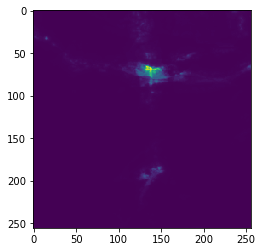

In [2]:
import matplotlib.pyplot as plt

window = windows[4000]
data = src.read(1, window=window)
print(np.shape(data))
bounds = rasterio.windows.bounds(window, src.transform)
print('bounds = {}'.format(bounds))
left, bottom, right, top = bounds # deconstruct tuple
center = (np.mean([left, right]), np.mean([bottom, top]))
print('center point: {}'.format(center))
print('total population: {}'.format(np.sum(data)))
plt.imshow(data)

Loop all windows and send the total population to Kafka.

In [3]:
from tqdm.notebook import tqdm

for window in tqdm(windows):
    data = src.read(1, window=window, masked=True)
    total = np.sum(data)
    bounds = rasterio.windows.bounds(window, src.transform)
    left, bottom, right, top = bounds
    center = (np.mean([left, right]), np.mean([bottom, top]))
    
    # skip empty windows
    if not total > 0:
        continue
    
    # construct geojson geometry - a point
    geom = {
        'type': 'Point',
        'coordinates': center
    }
    # construct geojson feature
    feature = {
        'type': 'Feature', 
        'properties': {'raster_val': str(total)}, # use str(total) because else not serializable
        'geometry': geom
    }
    
    # send to Kafka
    producer.send('2020_pop_points', value=feature)